## Aim of Study
The aim of this study is to evaluate and compare the performance of multiple classification algorithms in predicting customer churn, identifying which methods most accurately estimate churn risk based on available features.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import warnings
pd.set_option('display.expand_frame_repr', False)  # keep everything on one line
warnings.filterwarnings('ignore')

## Read in Data and EDA 

In [2]:
df = pd.read_csv("/Users/emudr/Desktop/data/BankCustomerChurnPrediction.csv")
print(df.describe())
print(df.info())
print(df.isna().sum())
print(df.duplicated().sum())
## No nulls, no duplicated, no outliers 

        customer_id  credit_score           age        tenure        balance  products_number  credit_card  active_member  estimated_salary         churn
count  1.000000e+04  10000.000000  10000.000000  10000.000000   10000.000000     10000.000000  10000.00000   10000.000000      10000.000000  10000.000000
mean   1.569094e+07    650.528800     38.921800      5.012800   76485.889288         1.530200      0.70550       0.515100     100090.239881      0.203700
std    7.193619e+04     96.653299     10.487806      2.892174   62397.405202         0.581654      0.45584       0.499797      57510.492818      0.402769
min    1.556570e+07    350.000000     18.000000      0.000000       0.000000         1.000000      0.00000       0.000000         11.580000      0.000000
25%    1.562853e+07    584.000000     32.000000      3.000000       0.000000         1.000000      0.00000       0.000000      51002.110000      0.000000
50%    1.569074e+07    652.000000     37.000000      5.000000   97198.540000

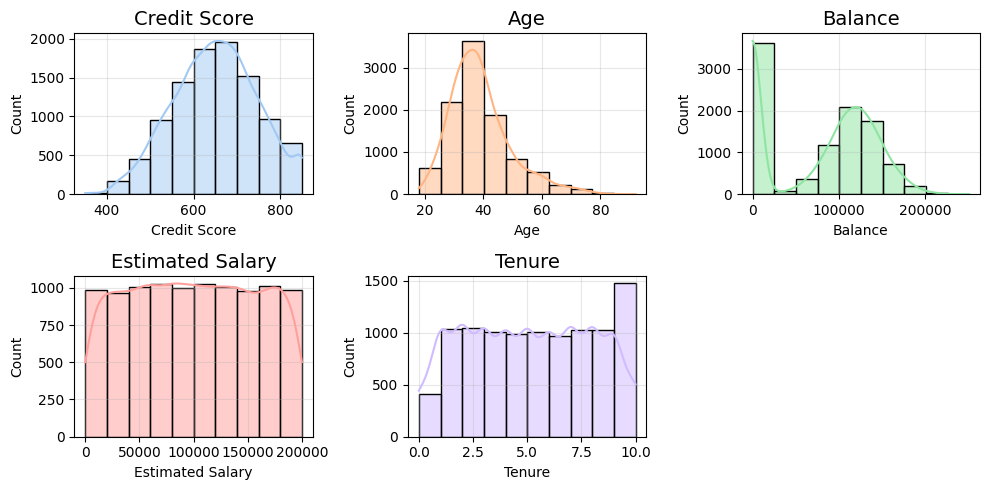

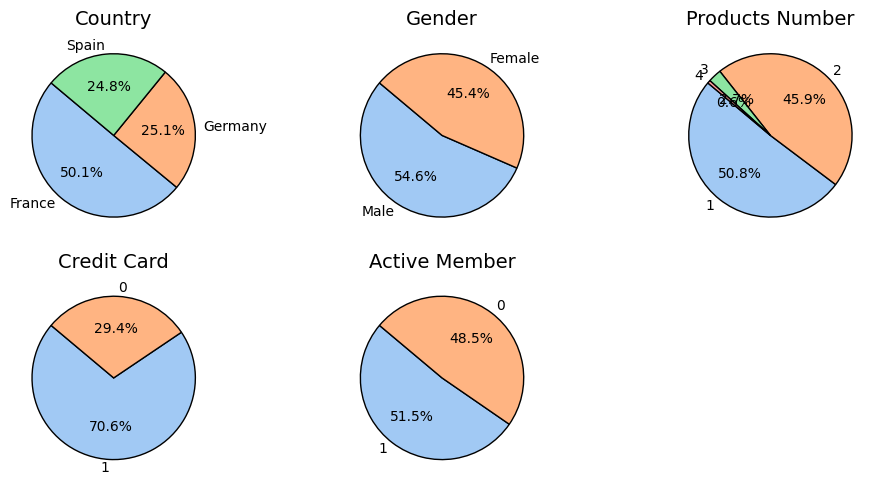

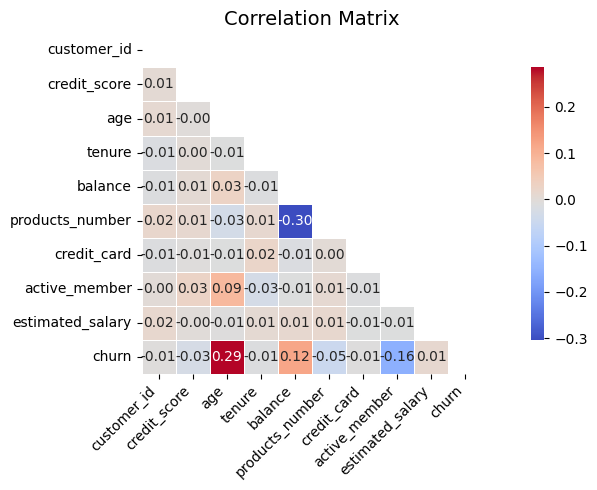

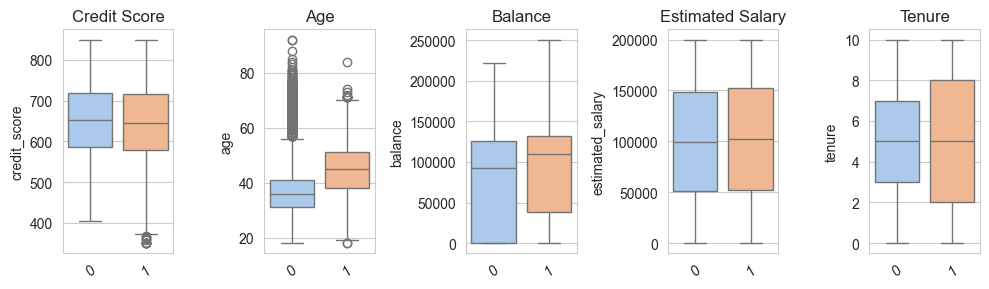

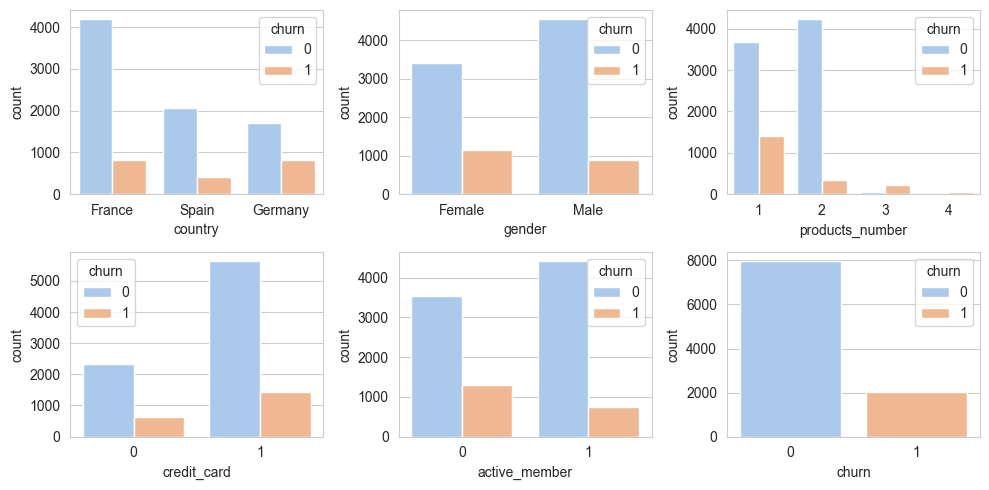

In [3]:
num_vars = ['credit_score', 'age', 'balance', 'estimated_salary', 'tenure']
cat_vars = ['country', 'gender', 'products_number', 'credit_card', 'active_member', 'churn']

def remove_unused_plots(num_vars, axs, fig):
    if len(num_vars) < len(axs):
        for j in range(len(num_vars), len(axs)):
            fig.delaxes(axs[j])
    return fig 
    


## Histplots
fig, axs = plt.subplots(2, 3, figsize=(10,5))
axs = axs.flatten()
colors = sns.color_palette("pastel")

for i, num_var in enumerate(num_vars):
    sns.histplot(df[num_var], kde=True, ax=axs[i], color=colors[i % len(colors)], edgecolor='k', bins=10)
    axs[i].set_title(num_var.replace('_',' ').title(), fontsize=14)
    axs[i].set_xlabel(num_var.replace('_',' ').title())
    axs[i].grid(True, alpha=0.3)

fig = remove_unused_plots(num_vars, axs, fig) 
plt.tight_layout()
plt.show()


## Pie plots
fig, axs = plt.subplots(2, 3, figsize=(10,5))
axs = axs.flatten()
colors = sns.color_palette("pastel")

for i, cat_var in enumerate(cat_vars):
    value_counts = df[cat_var].value_counts(dropna=False)
    wedges, texts, autotexts = axs[i].pie(
        value_counts, 
        labels=value_counts.index, 
        autopct='%1.1f%%', 
        colors=colors, 
        startangle=140, 
        wedgeprops={'edgecolor': 'k'}
    )
    axs[i].set_title(cat_var.replace('_',' ').title(), fontsize=14)

fig = remove_unused_plots(num_vars, axs, fig) 
plt.tight_layout()
plt.show()


## Correlation Matrix
plt.figure(figsize=(10,5))
corr = df.corr(numeric_only = True)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    mask=mask, 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8}, 
    square=True,
    annot_kws={"size":10}
)
plt.title("Correlation Matrix", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Boxplots
sns.set_style("whitegrid")
fig, axs = plt.subplots(1,5, figsize=(10,3))
axs = axs.flatten()
for i, var in enumerate(num_vars):
    sns.boxplot(x='churn', y=var, data=df, ax=axs[i], palette='pastel')
    axs[i].set_title(var.replace('_', ' ').title(), fontsize=12)
    axs[i].set_xlabel('')
    axs[i].set_ylabel(var, fontsize=10)
    axs[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()


sns.set_style("whitegrid")
fig, axs = plt.subplots(2,3, figsize=(10,5))
axs = axs.flatten()
for i, var in enumerate(cat_vars):
    sns.countplot(x=var ,hue = 'churn', data=df, ax = axs[i], palette='pastel')  
plt.tight_layout()
plt.show()

##

## Preprocessing

In [4]:
num_vars = ['credit_score', 'age', 'balance', 'estimated_salary', 'tenure']
cat_vars = ['country', 'gender', 'products_number', 'credit_card', 'active_member']

# Assign X and y
features = num_vars + cat_vars

X = df[features]
y = df['churn']
print(X)
print(y)
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for Logistic Regression, Naive Bayes, and SVMs - scale numeric variables, encode categorical vars
preprocessor1 = ColumnTransformer(transformers=[('num', StandardScaler(), num_vars), ('cat', OneHotEncoder(drop='first'), cat_vars)])
X_train_scaled_encoded = preprocessor1.fit_transform(X_train)
X_test_scaled_encoded = preprocessor1.transform(X_test)


# Preprocessing for Decision Trees, Random Forests, Boosting - only encode categorical vars (no scaling needed)
preprocessor2 = ColumnTransformer(transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_vars)], remainder="passthrough")   # keep numeric as-is
X_train_encoded = preprocessor2.fit_transform(X_train)
X_test_encoded = preprocessor2.transform(X_test)

print(X_train_scaled_encoded.shape)
print(X_test_scaled_encoded.shape)

      credit_score  age    balance  estimated_salary  tenure  country  gender  products_number  credit_card  active_member
0              619   42       0.00         101348.88       2   France  Female                1            1              1
1              608   41   83807.86         112542.58       1    Spain  Female                1            0              1
2              502   42  159660.80         113931.57       8   France  Female                3            1              0
3              699   39       0.00          93826.63       1   France  Female                2            0              0
4              850   43  125510.82          79084.10       2    Spain  Female                1            1              1
...            ...  ...        ...               ...     ...      ...     ...              ...          ...            ...
9995           771   39       0.00          96270.64       5   France    Male                2            1              0
9996           5

## Model Building

LogisticRegression(random_state=42)
Accuracy: 0.843
Precision: 0.6908212560386473
Recall: 0.3638676844783715
ROC AUC: 0.662020961094195

LogisticRegression(class_weight='balanced', random_state=42)
Accuracy: 0.7645
Precision: 0.44281524926686217
Recall: 0.7684478371501272
ROC AUC: 0.7659911867766815

GaussianNB()
Accuracy: 0.8235
Precision: 0.7941176470588235
Recall: 0.13740458015267176
ROC AUC: 0.5643463473258692

GaussianNB(priors=[0.4, 0.6])
Accuracy: 0.8235
Precision: 0.7941176470588235
Recall: 0.13740458015267176
ROC AUC: 0.5643463473258692

SVC(C=1, probability=True, random_state=42)
Accuracy: 0.8605
Precision: 0.8
Recall: 0.38676844783715014
ROC AUC: 0.6815609507387368

SVC(C=1, class_weight='balanced', probability=True, random_state=42)
Accuracy: 0.7875
Precision: 0.47492163009404387
Recall: 0.7709923664122137
ROC AUC: 0.7812646959627962

SVC(C=1, class_weight='balanced', kernel='linear', probability=True,
    random_state=42)
Accuracy: 0.772
Precision: 0.45263157894736844
Reca

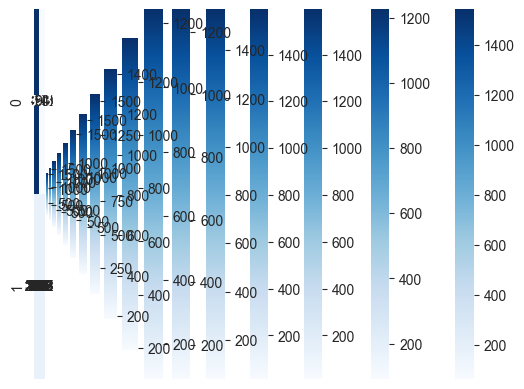

In [5]:
def model_and_evaluation(X_train, X_test, y_train, y_test, model):
    print(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    cm = confusion_matrix(y_test, y_pred)
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    print()
    #plt.show()


## Logistic Regression
model = LogisticRegression(random_state=42) 
model_and_evaluation(X_train_scaled_encoded, X_test_scaled_encoded, y_train, y_test, model)

model = LogisticRegression(class_weight = 'balanced' , random_state=42) 
model_and_evaluation(X_train_scaled_encoded, X_test_scaled_encoded, y_train, y_test, model)

## Naive Bayes (Guassian)
model = GaussianNB()
model_and_evaluation(X_train_scaled_encoded, X_test_scaled_encoded, y_train, y_test, model)

model = GaussianNB(priors=[0.4, 0.6])
model_and_evaluation(X_train_scaled_encoded, X_test_scaled_encoded, y_train, y_test, model)


## SVM
model = SVC(C=1, random_state = 42, kernel = 'rbf', probability = True)
model_and_evaluation(X_train_scaled_encoded, X_test_scaled_encoded, y_train, y_test, model)

model = SVC(C=1, random_state = 42, kernel = 'rbf', probability = True, class_weight = 'balanced')
model_and_evaluation(X_train_scaled_encoded, X_test_scaled_encoded, y_train, y_test, model)

model = SVC(C=1, random_state = 42, kernel = 'linear', probability = True, class_weight = 'balanced')
model_and_evaluation(X_train_scaled_encoded, X_test_scaled_encoded, y_train, y_test, model)


## Decision Tree
model = DecisionTreeClassifier(random_state=42)
model_and_evaluation(X_train_encoded, X_test_encoded, y_train, y_test, model)

model = DecisionTreeClassifier(class_weight = 'balanced' , random_state=42)
model_and_evaluation(X_train_encoded, X_test_encoded, y_train, y_test, model)

## Random Forests
model = RandomForestClassifier(random_state = 42)
model_and_evaluation(X_train_encoded, X_test_encoded, y_train, y_test, model)

model = RandomForestClassifier(random_state = 42, class_weight = 'balanced' )
model_and_evaluation(X_train_encoded, X_test_encoded, y_train, y_test, model)


## Boosting
model = GradientBoostingClassifier(random_state = 42)
model_and_evaluation(X_train_encoded, X_test_encoded, y_train, y_test, model)

model = GradientBoostingClassifier(random_state = 42, learning_rate = 2)
model_and_evaluation(X_train_encoded, X_test_encoded, y_train, y_test, model)

## XGBoost
model  = XGBClassifier(random_state=42, eval_metric="logloss", scale_pos_weight=8000/2000)
model_and_evaluation(X_train_encoded, X_test_encoded, y_train, y_test, model)
model  = XGBClassifier(random_state=42, eval_metric="logloss", learning_rate = 2)
model_and_evaluation(X_train_encoded, X_test_encoded, y_train, y_test, model)


## ADA boost
model = AdaBoostClassifier(random_state = 42)
model_and_evaluation(X_train_encoded, X_test_encoded, y_train, y_test, model)

model = AdaBoostClassifier(random_state = 42, learning_rate = 1.8)
model_and_evaluation(X_train_encoded, X_test_encoded, y_train, y_test, model)

## Results
**Key Metrics for Churn Prediction**
- For banking churn, Recall and ROC AUC are usually more important than Accuracy:
Recall (Sensitivity) → We want to catch as many churners as possible. Missing a churner costs revenue.
Precision → Important if retention campaigns are expensive (we don’t want too many false positives).
ROC AUC → Good overall separation measure, independent of class threshold.

**Balanced logistic regression & SVC**
- High recall (0.77), best ROC AUC (~0.77–0.78)
- Sacrifices accuracy & precision → acceptable if catching churners is more critical

**Random Forest / Gradient Boosting / XGBoost**
- Default settings → decent balance, slightly better precision than balanced linear models

**GaussianNB**
- Performs poorly for imbalanced churn dataset, recall too low
- Class priors do not help much

**AdaBoost with aggressive learning rate**
- Extreme overfitting → predicts all churners, not realistic

## Next Steps
- Primary goal: catch as many churners as possible → maximize recall & ROC AUC

**Best options:**
- LogisticRegression(class_weight='balanced')
- SVC(class_weight='balanced') (RBF or Linear)


## Adjust Classification Threshold for Logistic Regression and SVC

In [ ]:

def model_adj_threshold(X_train, X_test, y_train, y_test, model):
    print(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")

    # Predict probabilities
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Get precision-recall pairs
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
    
    # Example: choose threshold that maximizes F1
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    best_idx = f1_scores.argmax()
    best_threshold = thresholds[best_idx]
    
    print("Best threshold:", best_threshold)
    print("Precision:", precisions[best_idx])
    print("Recall:", recalls[best_idx])
    print("F1:", f1_scores[best_idx])

    # Apply new threshold
    y_pred_adjusted = (y_probs >= best_threshold).astype(int)
    print("ROC AUC:", roc_auc_score(y_test, y_probs))

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
    print("Mean CV F1 (train set):", scores.mean())

    # Final unbiased test evaluation
    print("Test F1:", f1_score(y_test, y_pred_adjusted))
    print()


## Logistic Regression
model = LogisticRegression(random_state=42) 
model_adj_threshold(X_train_scaled_encoded, X_test_scaled_encoded, y_train, y_test, model)

## SVC
model = SVC(C=1, random_state = 42, kernel = 'rbf', probability = True, class_weight = 'balanced')
model_adj_threshold(X_train_scaled_encoded, X_test_scaled_encoded, y_train, y_test, model)

LogisticRegression(random_state=42)
Accuracy: 0.843
Precision: 0.6908212560386473
Recall: 0.3638676844783715
Best threshold: 0.27307619701901675
Precision: 0.5085714285714286
Recall: 0.6793893129770993
F1: 0.5816993464052287
ROC AUC: 0.8371342931924738
Mean CV F1 (train set): 0.5002480992886772
Test F1: 0.5816993464052288

SVC(C=1, class_weight='balanced', probability=True, random_state=42)
Accuracy: 0.7875
Precision: 0.47492163009404387
Recall: 0.7709923664122137
Best threshold: 0.3514057862575736
Precision: 0.5899772209567198
Recall: 0.6590330788804071
F1: 0.6225961538461537
ROC AUC: 0.8529034076424549


## Churn Prediction Model Evaluation Conclusion
- Two models were evaluated for predicting customer churn: Logistic Regression and Support Vector Classifier (SVC) with class weighting and threshold tuning.

**Logistic Regression:**
- Baseline accuracy was high at 0.84, but recall was low (0.36), meaning many churners were initially missed.
- After adjusting the classification threshold to 0.27, recall increased to 0.68, improving the model’s ability to identify churners while maintaining moderate precision (0.51).
- The F1-score improved to 0.58, and ROC AUC reached 0.84, indicating good overall discriminative ability.
- Cross-validation on the training set showed stable performance (mean CV F1 ≈ 0.50), confirming generalizability.

**SVC (class-weighted):**
- Initially favored recall (0.77) due to class weighting, with lower precision (0.47).
- After threshold tuning to 0.35, the model achieved a balanced F1-score of 0.62, with precision 0.59 and recall 0.66.
- ROC AUC of 0.85 suggests slightly better separability than Logistic Regression.

## Overall Interpretation:
- Both models benefit significantly from threshold tuning, which improves recall for identifying churners — a priority in retention strategies.
- SVC provides a slightly better balance between precision and recall (higher F1 and ROC AUC), while Logistic Regression achieves higher recall at the cost of precision.
- Both models are suitable for deployment, with the choice depending on whether the business prioritizes catching as many churners as possible (Logistic Regression) or balancing false positives and false negatives (SVC).